## Data preparation

For tuning the ML models and augmentation parameters, we need to split the train set into a train set and validation set. If we were to use temporal info later, we need to separate storms instead of images.



In [77]:
from separate_val_data import separate_val_files 

In [78]:
train_dir = 'data/train'
val_dir = 'data/val' 
# val dictionary should not exist, otherwise, it would raise error to avoid runnig it multiple times.
val_fr = 0.2

separate_val_files(train_dir, val_dir, val_fr)

ValueError: data/val already exist.

## Directory structure

```
project
|____data
|    |____train
|    |     |___abc_001.jpg
|    |     |___abc_002.jpg
|    |
|    |____val
|    |     |___acc_001.jpg
|    |     |___acc_002.jpg
|    |
|    |____training_set_features.csv
|    |____training_set_labels.csv
|____separate_val_data.py
|____image_batch_gen.py
|____Hurricane.ipynb
```

## Make batch

In [4]:
import os
from os.path import join, dirname
import pandas as pd
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import random

In [14]:
class ImgBatchGen(tf.keras.utils.Sequence):
    def __init__(self, img_dir, ground_truth_file, batch_size=32, img_size=None):
        self.bacth_size = batch_size
        files = os.listdir(img_dir)
        label_df = pd.read_csv(ground_truth_file, index_col=0, header=0)
        self.files = [(join(img_dir, f), label_df.loc[f[:7], 'wind_speed']) for f in files if f.endswith('.jpg')]
        random.shuffle(self.files)
        self.img_size=img_size
        
    def __len__(self):
        return min(1000, int(np.floor(len(self.files)/self.bacth_size)))

    def __getitem__(self, index):
        images, labels = [], []

        for file, label in self.files[index*self.bacth_size:(index+1)*self.bacth_size]:
            img = cv2.imread(file, 0)
            if img is None:
                continue
            if self.img_size is not None:
                img = cv2.resize(img,(self.img_size, self.img_size), interpolation = cv2.INTER_CUBIC)
            images.append(img)
            labels.append(label)

        x = np.array(images)[:, :, :, np.newaxis].astype(np.float32) / 255.0
        y = np.array(labels).astype(np.float32)

        return x, y
    def on_epoch_end(self):
        random.shuffle(self.files)
    

In [3]:
class ImgBatchGenOneShot(tf.keras.utils.Sequence):
    def __init__(self, img_dir, ground_truth_file, batch_size=32, img_size=None):
        self.bacth_size = batch_size
        self.img_size=img_size
        files = os.listdir(img_dir)
        label_df = pd.read_csv(ground_truth_file, index_col=0, header=0)
        self.files = [(join(img_dir, f), label_df.loc[f[:7], 'wind_speed']) for f in files if f.endswith('.jpg')]
        random.shuffle(self.files)
        
        images, labels = [], []
        for file, label in self.files:
            img = cv2.imread(file, 0)
            if img is None:
                continue
            if self.img_size is not None:
                img = cv2.resize(img,(self.img_size, self.img_size), interpolation = cv2.INTER_CUBIC)
            images.append(img)
            labels.append(label)
        x = np.array(images)[:, :, :, np.newaxis].astype(np.float32) / 255.0
        y = np.array(labels).astype(np.float32)
            
        self.x = x
        self.y = y
        print('x shape', self.x.shape)
        print('y shape', self.y.shape)
        
        #
        
    def __len__(self):
        return int(np.floor(len(self.files)/self.bacth_size))

    def __getitem__(self, index):
        images, labels = [], []
        
        x_batch = self.x[index*self.bacth_size:(index+1)*self.bacth_size, :, :]
        y_batch = self.y[index*self.bacth_size:(index+1)*self.bacth_size]

#         for file, label in self.files[index*self.bacth_size:(index+1)*self.bacth_size]:
#             img = cv2.imread(file, 0)
#             if img is None:
#                 continue
#             if self.img_size is not None:
#                 img = cv2.resize(img,(self.img_size, self.img_size), interpolation = cv2.INTER_CUBIC)
#             images.append(img)
#             labels.append(label)

#         x = np.array(images)[:, :, :, np.newaxis].astype(np.float32) / 255.0
#         y = np.array(labels).astype(np.float32)

        return x_batch, y_batch

In [15]:
img_size = 366
train_batchgen = ImgBatchGen('data/train_aug', 'data/training_set_labels.csv', 32, img_size=None)
val_batchgen = ImgBatchGen('data/val', 'data/training_set_labels.csv', 32, img_size=None)

(32, 366, 366, 1) (32,)
35.0


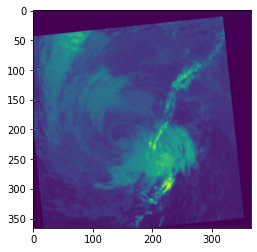

In [16]:
train_x, train_y = train_batchgen[0]
print(train_x.shape, train_y.shape)
plt.imshow(train_x[2])
print(train_y[2])

## Make Model

In [17]:
from tensorflow.keras.layers import Conv2D, Dense, GlobalAveragePooling2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint

In [18]:
model = Sequential()
model.add(Conv2D(32, (7,7), padding='same', activation='selu', input_shape=(img_size, img_size, 1)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', activation='selu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', activation='selu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', activation='selu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', activation='selu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', activation='selu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', activation='selu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', activation='selu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', activation='selu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', activation='selu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', activation='selu'))
model.add(Flatten())
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(Dense(32, activation='selu'))
model.add(Dense(1, activation='linear'))

In [19]:
checkpoint = ModelCheckpoint('model6_best', monitor='val_mse', verbose=1, save_best_only=True, mode='min') 

In [20]:
model.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae', 'mape'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 366, 366, 32)      1600      
_________________________________________________________________
batch_normalization_12 (Batc (None, 366, 366, 32)      128       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 366, 366, 64)      18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 183, 183, 64)      0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 183, 183, 64)      256       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 183, 183, 64)      36928     
_________________________________________________________________
batch_normalization_14 (Batc (None, 183, 183, 64)     

In [21]:
## Train

In [22]:
history = model.fit(train_batchgen, epochs = 100, verbose=1, validation_data=val_batchgen, callbacks=[checkpoint])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1000 steps, validate for 422 steps
Epoch 1/100
 999/1000 [============================>.] - ETA: 0s - loss: 502.1308 - mse: 502.1307 - mae: 16.6250 - mape: 35.9572
Epoch 00001: val_mse improved from inf to 483.89554, saving model to model6_best
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model6_best\assets
1000/1000 [==============================] - 519s 519ms/step - loss: 501.8310 - mse: 501.8308 - mae: 16.6181 - mape: 35.9386 - val_loss: 483.8955 - val_mse: 483.8955 - val_mae: 17.2878 - val_mape: 38.4212
Epoch 2/100
 999/1000 [============================>.] - ETA: 0s - loss: 244.8705 - mse: 244.8706 - mae: 11.8272 - mape: 26.2436
Epoch 00002: val_mse improved from 483.89554 to 225.00792, saving model to model6_best
INFO:tensorflow:Assets written to: model6_best\assets
1000/1000 [==============================] - 349s 349ms/step - loss: 244.7925 - mse: 

Epoch 20/100
 999/1000 [============================>.] - ETA: 0s - loss: 67.3912 - mse: 67.3913 - mae: 6.3331 - mape: 14.3095
Epoch 00020: val_mse did not improve from 105.88308
1000/1000 [==============================] - 330s 330ms/step - loss: 67.4122 - mse: 67.4122 - mae: 6.3341 - mape: 14.3117 - val_loss: 122.8045 - val_mse: 122.8045 - val_mae: 8.3667 - val_mape: 20.2352
Epoch 21/100
 999/1000 [============================>.] - ETA: 0s - loss: 64.2588 - mse: 64.2588 - mae: 6.2001 - mape: 14.0411
Epoch 00021: val_mse did not improve from 105.88308
1000/1000 [==============================] - 330s 330ms/step - loss: 64.2265 - mse: 64.2265 - mae: 6.1986 - mape: 14.0377 - val_loss: 122.1205 - val_mse: 122.1205 - val_mae: 8.1939 - val_mape: 18.9358
Epoch 22/100
 999/1000 [============================>.] - ETA: 0s - loss: 61.0671 - mse: 61.0671 - mae: 6.0527 - mape: 13.6902
Epoch 00022: val_mse did not improve from 105.88308
1000/1000 [==============================] - 330s 330ms/step 

Epoch 42/100
 999/1000 [============================>.] - ETA: 0s - loss: 33.6291 - mse: 33.6291 - mae: 4.5394 - mape: 10.5067
Epoch 00042: val_mse did not improve from 105.88308
1000/1000 [==============================] - 330s 330ms/step - loss: 33.6271 - mse: 33.6271 - mae: 4.5394 - mape: 10.5060 - val_loss: 126.7650 - val_mse: 126.7650 - val_mae: 8.4174 - val_mape: 19.6756
Epoch 43/100
 999/1000 [============================>.] - ETA: 0s - loss: 32.4175 - mse: 32.4175 - mae: 4.4506 - mape: 10.2713
Epoch 00043: val_mse did not improve from 105.88308
1000/1000 [==============================] - 330s 330ms/step - loss: 32.4189 - mse: 32.4189 - mae: 4.4502 - mape: 10.2711 - val_loss: 139.6318 - val_mse: 139.6318 - val_mae: 8.9379 - val_mape: 21.5510
Epoch 44/100
 999/1000 [============================>.] - ETA: 0s - loss: 31.6922 - mse: 31.6922 - mae: 4.3974 - mape: 10.2170
Epoch 00044: val_mse did not improve from 105.88308
1000/1000 [==============================] - 329s 329ms/step 

Epoch 64/100
 999/1000 [============================>.] - ETA: 0s - loss: 24.6058 - mse: 24.6058 - mae: 3.8895 - mape: 9.0047
Epoch 00064: val_mse did not improve from 105.88308
1000/1000 [==============================] - 329s 329ms/step - loss: 24.6160 - mse: 24.6159 - mae: 3.8904 - mape: 9.0075 - val_loss: 115.0842 - val_mse: 115.0843 - val_mae: 8.1091 - val_mape: 19.4461
Epoch 65/100
 999/1000 [============================>.] - ETA: 0s - loss: 24.7475 - mse: 24.7475 - mae: 3.8938 - mape: 9.0241
Epoch 00065: val_mse did not improve from 105.88308
1000/1000 [==============================] - 329s 329ms/step - loss: 24.7517 - mse: 24.7518 - mae: 3.8940 - mape: 9.0222 - val_loss: 126.6770 - val_mse: 126.6770 - val_mae: 8.4038 - val_mape: 19.0606
Epoch 66/100
 999/1000 [============================>.] - ETA: 0s - loss: 24.6167 - mse: 24.6167 - mae: 3.8792 - mape: 9.0053
Epoch 00066: val_mse did not improve from 105.88308
1000/1000 [==============================] - 330s 330ms/step - los

KeyboardInterrupt: 

In [11]:
model.save('model_3')


INFO:tensorflow:Assets written to: model_3\assets


In [14]:
ground_truth = []
pred = []
i = 0
for x_batch, y_batch in val_batchgen:
    pred.append(model.predict(x_batch).ravel())
    ground_truth.append(y_batch)
pred = np.hstack(pred)
ground_truth = np.hstack(ground_truth)

Text(0, 0.5, 'Prediction')

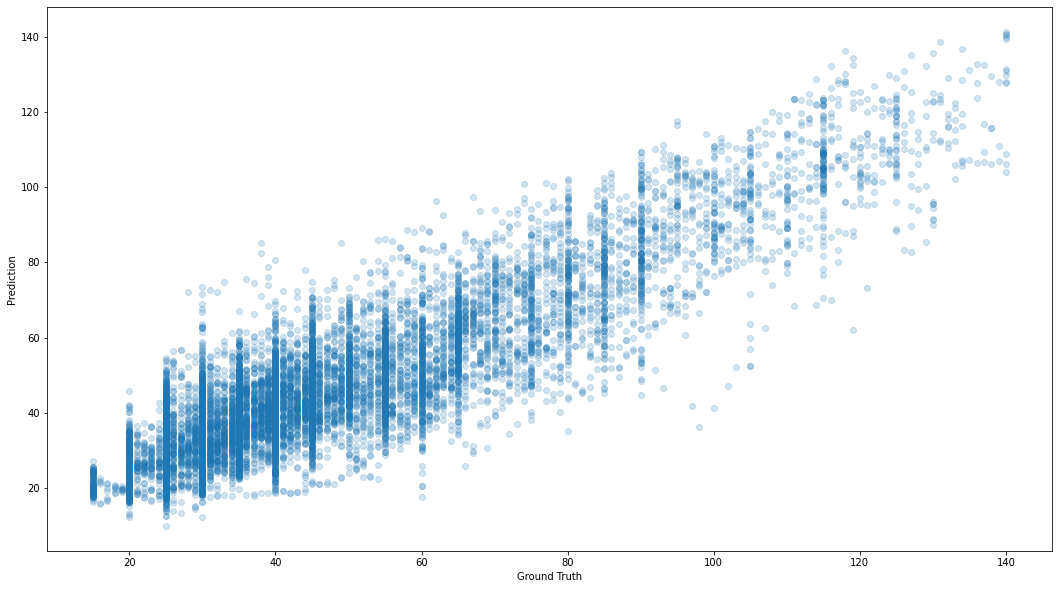

In [15]:
plt.figure(figsize=(18, 10))
plt.scatter(ground_truth, pred, alpha=0.2)
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')

In [21]:
a = np.array(range(1000))

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
       [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
       [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
       [40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
       [50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
       [60, 61, 62, 63, 64, 65, 66, 67, 68, 69],
       [70, 71, 72, 73, 74, 75, 76, 77, 78, 79],
       [80, 81, 82, 83, 84, 85, 86, 87, 88, 89],
       [90, 91, 92, 93, 94, 95, 96, 97, 98, 99]])

In [51]:
class ImgBatchGenTest(tf.keras.utils.Sequence):
    def __init__(self, img_dir, batch_size=32, img_size=None):
        self.bacth_size = batch_size
        files = os.listdir(img_dir)
        self.files = [(join(img_dir, f), f) for f in files if f.endswith('.jpg')]
        
        self.img_size=img_size
        
    def __len__(self):
        return int(np.ceil(len(self.files)/self.bacth_size))

    def __getitem__(self, index):
        images = []
        labels = []

        for file, filename in self.files[index*self.bacth_size:(index+1)*self.bacth_size]:
            img = cv2.imread(file, 0)
            if img is None:
                continue
            if self.img_size is not None:
                img = cv2.resize(img,(self.img_size, self.img_size), interpolation = cv2.INTER_CUBIC)
            images.append(img)
            labels.append(filename)
  

        x = np.array(images)[:, :, :, np.newaxis].astype(np.float32) / 255.0
        y = np.array(labels)

        return x, y
    

In [52]:
test_batchgen = ImgBatchGenTest('data/test', 32, img_size=None)

(32, 366, 366, 1) (32,)
acd_127.jpg


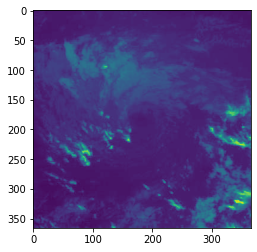

In [53]:

test_im, test_fname = test_batchgen[0]
print(test_im.shape, test_fname.shape)
plt.imshow(test_im[4])
print(test_fname[4])

In [54]:

from tensorflow import keras
model = keras.models.load_model('model4_best/')

In [55]:

predictions = model.predict(test_batchgen)

In [57]:
len(predictions)


44377

In [74]:
filenames = [f[1].split('.')[0] for f in test_batchgen.files]
len(filenames)

44377

In [75]:
submission_df = pd.DataFrame()
submission_df["image_id"] = np.array(filenames)
submission_df["wind_speed"] = np.array(predictions)
submission_df['image_id'] = submission_df.astype(str)
submission_df['wind_speed'] = submission_df['wind_speed'].round(0).astype(int)
submission_df = submission_df.sort_values(['image_id'])
submission_df.head(10)

,image_id,wind_speed
0,acd_123,26
1,acd_124,25
2,acd_125,26
3,acd_126,27
4,acd_127,28
5,acd_128,29
6,acd_129,29
7,acd_130,28
8,acd_131,27
9,acd_132,28


In [76]:
submission_df.to_csv("submission2.csv", index=False)